# Personalized correlations PNP3

 *Wake up glucose vs diet the day before*

The idea is that wakeup glucose is not the same on different days for the same person. I want to understand if it is due to the dietal behavior the day before. Also I want to see if associations between the food in the previous day and the wakeup glucose are different for different people. PNP3 cohort is suitable for this purpose because each person had more than 100 days of CGM connections.

I have to start with computing the wakeup glucose for all the people and each day. The method is to use the time between 6 and 7 unless a person logged the food at this time. Also I have to filter out days and people who logged any food after midnight.

In [1]:
import pandas as pd
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
import datetime
%matplotlib inline
cgml = CGMLoader()
dll = DietLoggingLoader()

In [121]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

## Calculating wakeup glucose

In [5]:
cgmdf = cgml.get_data(study_ids=[3,49]).df
cgmdf = cgml._remove_first_day_of_connections(cgmdf)

In [6]:
cgmdf = cgmdf.reset_index()
cgmdf['hour'] = cgmdf.Date.dt.hour
cgmdf = cgmdf.set_index('Date')
cgmdf.index = cgmdf.index.tz_localize(None)

In [7]:
cgmdf['RegistrationCode'].nunique()

263

In [3]:
adj_gluc = pd.read_json('/home/elming/Cache/adj_gl.json')
adj_gluc['ConnectionID'] = adj_gluc['ConnectionID'].astype(str)
adj_gluc['GlucoseTimestamp'] = pd.to_datetime(adj_gluc['GlucoseTimestamp'])
adj_gluc = adj_gluc.rename(columns={'GlucoseTimestamp':'Date'})

In [8]:
adj_gluc = adj_gluc.set_index(['ConnectionID', 'Date'])
cgm_adj = pd.merge(cgmdf, adj_gluc['GlucoseAdj50N13_Mm'], on=['ConnectionID', 'Date'])
cgm_adj = cgm_adj.rename(columns={'GlucoseAdj50N13_Mm':'GlucoseAdj'})

In [10]:
cgm_adj['RegistrationCode'].nunique()

219

In [11]:
log = dll.get_data(study_ids=[3,49]).df

In [12]:
logdf = dll.add_nutrients(log, ['energy_kcal'])

In [13]:
logdf = dll.squeeze_log(logdf)

In [14]:
logdf = logdf.reset_index()
logdf['Day'] = logdf['Date'].dt.date

In [15]:
logdf = logdf[logdf['energy_kcal'] != 0]

In [16]:
logdf.head()

,RegistrationCode,Date,energy_kcal,weight,meal_type,Day
0,111527,2017-10-06 09:46:44+03:00,2.500000,490.000000,Beverage,2017-10-06
1,111527,2017-10-06 11:48:01+03:00,147.000000,560.000000,Meal,2017-10-06
2,111527,2017-10-06 11:53:29+03:00,78.057000,210.000000,Beverage,2017-10-06
5,111527,2017-10-06 14:25:24+03:00,740.724492,605.200001,Meal,2017-10-06
7,111527,2017-10-06 17:11:29+03:00,136.500000,296.000000,Snack,2017-10-06


In [53]:
firstmeals = pd.DataFrame(logdf.groupby(['RegistrationCode', 'Day'])['Date'].first().rename('breakfast_ts'))
firstmeals

breakfast_ts
RegistrationCode Day                                        
111527           2017-10-06        2017-10-06 09:46:44+03:00
                 2017-10-07        2017-10-07 09:34:22+03:00
                 2017-10-08        2017-10-08 08:56:41+03:00
                 2017-10-09        2017-10-09 01:02:14+03:00
                 2017-10-14        2017-10-14 09:03:31+03:00
...                                                      ...
997735           2019-10-28 2019-10-28 08:29:46.061000+02:00
                 2019-10-29 2019-10-29 07:30:22.533000+02:00
                 2019-10-30 2019-10-30 08:00:24.974000+02:00
                 2019-11-02 2019-11-02 08:00:34.291000+02:00
                 2019-11-03 2019-11-03 06:00:31.647000+02:00

[50492 rows x 1 columns]

In [54]:
firstmeals = firstmeals[(firstmeals['breakfast_ts'].dt.time > datetime.time(6, 0, 0))]

In [55]:
firstmeals = firstmeals.reset_index('Day')

In [56]:
firstmeals['Day'] = pd.to_datetime(firstmeals['Day'])

In [57]:
firstmeals = firstmeals.set_index('Day', append=True)

In [58]:
firstmeals.shape

(44884, 1)

In [59]:
cgm_adj.shape

(2965212, 5)

In [21]:
cgm_adj['Day'] = cgm_adj.index.date

In [26]:
cgm_adj = cgm_adj.set_index(['RegistrationCode', 'Day'])

In [40]:
firstmeals.index.get_level_values(1).dtype

dtype('<M8[ns]')

In [88]:
cgm_fm = pd.merge(cgm_adj, firstmeals, on=['RegistrationCode', 'Day'])

In [89]:
cgm_fm.shape

(2349082, 6)

In [90]:
cgm_fm

ConnectionID  ...                     breakfast_ts
RegistrationCode Day                      ...                                 
111527           2017-11-07         1926  ...        2017-11-07 06:47:38+02:00
                 2017-11-07         1926  ...        2017-11-07 06:47:38+02:00
                 2017-11-07         1926  ...        2017-11-07 06:47:38+02:00
                 2017-11-07         1926  ...        2017-11-07 06:47:38+02:00
                 2017-11-07         1926  ...        2017-11-07 06:47:38+02:00
...                                  ...  ...                              ...
997735           2019-11-03         6089  ... 2019-11-03 06:00:31.647000+02:00
                 2019-11-03         6089  ... 2019-11-03 06:00:31.647000+02:00
                 2019-11-03         6089  ... 2019-11-03 06:00:31.647000+02:00
                 2019-11-03         6089  ... 2019-11-03 06:00:31.647000+02:00
                 2019-11-03         6089  ... 2019-11-03 06:00:31.647000+02:00

[2349082 rows x 6 columns]

In [91]:
cgm_fm = cgm_fm[(cgm_fm['hour'] >= 5) & (cgm_fm['hour'] <= 6)]
cgm_fm.shape

(200553, 6)

In [93]:
cgm_fm = cgm_fm[((cgm_fm['hour'] ==5) & (cgm_fm['breakfast_ts'].dt.hour == 6)) | 
((cgm_fm['hour'] ==6) & (cgm_fm['breakfast_ts'].dt.hour >= 7)) ]

In [133]:
wakeup_glucose = pd.DataFrame(cgm_fm.reset_index().groupby(['RegistrationCode', 'Day', 'hour'])['GlucoseAdj'].mean().rename('wakeup_glucose'))

In [134]:
wakeup_glucose = wakeup_glucose.reset_index()

In [135]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def interquartile_range(x):
    return q3(x) - q1(x)

f = {'wakeup_glucose': ['median', 'std', q1,q3, interquartile_range]}

In [136]:
morn_gluc_distr = wakeup_glucose.groupby('RegistrationCode').agg(f)

In [137]:
morn_gluc_distr.sample(10)

wakeup_glucose             ...                                
                         median        std  ...          q3 interquartile_range
RegistrationCode                            ...                                
173854                87.145833  14.927984  ...   91.647321           12.959821
772380                96.250000   5.252915  ...  100.700000            7.562500
252002                97.649573   9.253903  ...  105.050000           12.130682
794542               126.634615  12.311187  ...  132.849359           10.974359
130279                99.375000  11.034922  ...  105.468750           10.883523
132178               109.375000   8.970829  ...  114.669643           11.794643
439484                95.250000  10.592360  ...   98.919643            8.453734
742096                92.333333   5.377542  ...   95.603147            7.487762
997427               107.766667   7.604173  ...  111.968531            8.697698
64952                 89.289773   8.936098  ...   94.250000            9.326705

[10 rows x 5 columns]

In [108]:
morn_gluc_distr.columns = morn_gluc_distr.columns.droplevel()

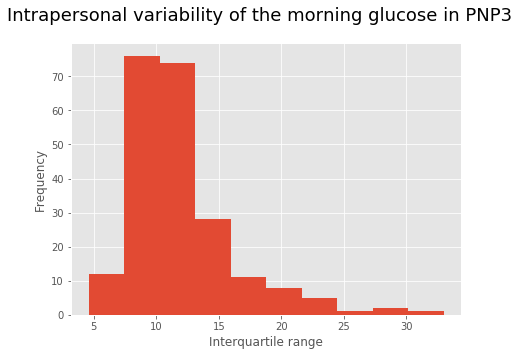

In [122]:
fig = plt.figure(figsize=(7,5))
fig.suptitle('Intrapersonal variability of the morning glucose in PNP3', fontsize=18)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Interquartile range')
morn_gluc_distr['interquartile_range'].plot.hist()

In [123]:
morn_gluc_distr['interquartile_range'].mean()

11.936180075658099

In [152]:
wakeup_glucose.shape

(25799, 4)

For how many days did people wear CGM sensor?

In [143]:
count = wakeup_glucose.groupby('RegistrationCode')['Day'].count()

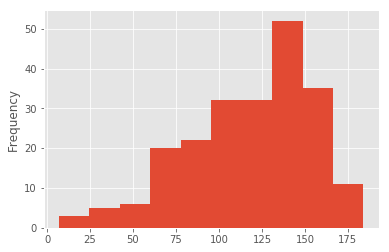

In [144]:
count.plot.hist()

In [149]:
rc_to_keep = count[count >= 50].index

Let's take all people with at least 50 days of  connections.

In [153]:
wakeup_glucose = wakeup_glucose.set_index('RegistrationCode').loc[rc_to_keep]

## Dietary features from the day before

Dietary features to test the correlations on:
'alcohol_g', 'caffeine_mg', 'carbohydrate_g', 'carbs/fat', 'energy_kcal', 'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g'

In [128]:
logdf = dll.add_nutrients(log,['alcohol_g', 'caffeine_mg', 'carbohydrate_g', 'energy_kcal', 
                       'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g'])

In [130]:
logdf = dll.squeeze_log(logdf)
logdf.head()

sodium_mg  ...  meal_type
RegistrationCode Date                                  ...           
111527           2017-10-06 09:46:44+03:00      9.800  ...   Beverage
                 2017-10-06 11:48:01+03:00    311.000  ...       Meal
                 2017-10-06 11:53:29+03:00     64.995  ...   Beverage
                 2017-10-06 13:17:55+03:00     14.400  ...   Beverage
                 2017-10-06 14:10:52+03:00     19.200  ...   Beverage

[5 rows x 11 columns]

In [131]:
logdf = logdf.reset_index()

In [155]:
logdf['Day'] = logdf['Date'].dt.date
logdf.head()

,RegistrationCode,Date,sodium_mg,sugarstotal_g,alcohol_g,totallipid_g,protein_g,carbohydrate_g,totaldietaryfiber_g,energy_kcal,weight,caffeine_mg,meal_type,Day
0,111527,2017-10-06 09:46:44+03:00,9.800,0.0,0.0,0.050,0.300,0.000,0.00,2.500,490.0,112.5,Beverage,2017-10-06
1,111527,2017-10-06 11:48:01+03:00,311.000,0.0,0.0,6.040,6.700,15.220,0.56,147.000,560.0,0.0,Meal,2017-10-06
2,111527,2017-10-06 11:53:29+03:00,64.995,0.0,0.0,3.906,4.284,6.363,0.00,78.057,210.0,50.4,Beverage,2017-10-06
3,111527,2017-10-06 13:17:55+03:00,14.400,0.0,0.0,0.000,0.000,0.000,0.00,0.000,720.0,0.0,Beverage,2017-10-06
4,111527,2017-10-06 14:10:52+03:00,19.200,0.0,0.0,0.000,0.000,0.000,0.00,0.000,960.0,0.0,Beverage,2017-10-06
